In [1]:
import json
import pandas as pd
import numpy as np

In [2]:
# 1) Load the entire JSON
with open('../optimizations/BettiZeroSegmentations2.json') as f:
    data = json.load(f)

### Building The Vector

In the preprint by Haruhisa Oda, he uses $N\times K\times m$ vectors, where $m$ is the number of longest bars, and $N$ is the number of projections, $K$ is the number of directions. Since I am using $3D$ persistence, I will use the same $m$ as in his papers $m=5$, but will not be doing $N\times K$.

In [3]:
seg_vectors = {}
# 2) Loop over each segmentation block...
for seg_name, seg_samples in data.items():
    if "-AI-" not in seg_name:
        pca_vector = []
        for val in seg_samples.values():
            for bar in val['largest_bars']:
                pca_vector.append(bar[1]-bar[0])      
        seg_vectors[seg_name] = pca_vector

### Conducting PCA

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Explained variance ratios: [0.65009224 0.11752335]


,PC1,PC2
25,-2.040992,-0.429692
20,-6.363790,-1.521591
52,2.319100,1.077369
48,5.071482,0.312183
36,-1.124287,0.198952


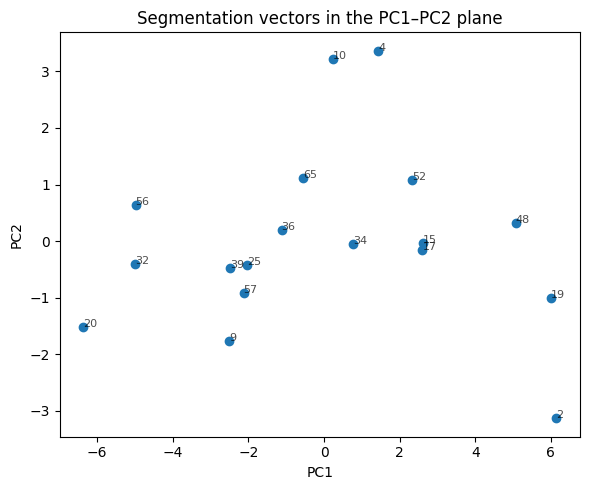

In [5]:
# -------------------------------------------------
# 1)  Pack the dict into a (n_samples, n_features) matrix
# -------------------------------------------------
names   = list(seg_vectors.keys())              # preserve order
X_array = np.vstack([seg_vectors[n] for n in names])

# -------------------------------------------------
# 2)  (Recommended) z-score the features
# -------------------------------------------------
scaler = StandardScaler()
X_std = scaler.fit_transform(X_array)

# -------------------------------------------------
# 3)  Fit PCA and get the scores
# -------------------------------------------------
pca = PCA(n_components=2, svd_solver='auto', random_state=0)
PC_scores = pca.fit_transform(X_std)         # shape: (n_samples, 2)

# Pack into a neat DataFrame
numbers = [int(s.split('-')[-1]) for s in names]
pca_scores = pd.DataFrame(PC_scores, columns=['PC1', 'PC2'], index=numbers)

# -------------------------------------------------
# 4)  Inspect results
# -------------------------------------------------
print('Explained variance ratios:', pca.explained_variance_ratio_)
display(pca_scores.head())

# Optional visualisation
plt.figure(figsize=(6, 5))
plt.scatter(pca_scores['PC1'], pca_scores['PC2'])
for txt, (x, y) in pca_scores.iterrows():
    plt.annotate(txt, (x, y), fontsize=8, alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Segmentation vectors in the PC1–PC2 plane')
plt.tight_layout()
plt.show()